In [1]:
import pandas as pd
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import river.metrics as metrics
import river.stream as stream
import seaborn as sns

In [2]:
#!pip install deep-river
#!pip install prettytable
#!pip install tabulate

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from torch import nn, manual_seed
from IPython.display import clear_output
from collections import deque, Counter
from river import metrics, preprocessing, compose, stream
from deep_river import classification
from prettytable import PrettyTable
from colorama import Fore, Style, init
from tabulate import tabulate
from sklearn.metrics import confusion_matrix

In [4]:
df = pd.read_csv('C:/Users/GCU/Downloads/CICIoT2023.csv')

In [5]:
#df = df.sample(frac=0.1, random_state=42)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280985 entries, 0 to 280984
Data columns (total 37 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    280985 non-null  float64
 1   Header_Length    280985 non-null  float64
 2   Protocol Type    280985 non-null  float64
 3   Duration         280985 non-null  float64
 4   Rate             280985 non-null  float64
 5   Srate            280985 non-null  float64
 6   fin_flag_number  280985 non-null  float64
 7   syn_flag_number  280985 non-null  float64
 8   rst_flag_number  280985 non-null  float64
 9   psh_flag_number  280985 non-null  float64
 10  ack_flag_number  280985 non-null  float64
 11  ack_count        280985 non-null  float64
 12  syn_count        280985 non-null  float64
 13  fin_count        280985 non-null  float64
 14  urg_count        280985 non-null  float64
 15  rst_count        280985 non-null  float64
 16  HTTP             280985 non-null  floa

In [7]:
print(df['label'].value_counts())

label
DDoS-UDP_Flood             54207
DDoS-SynonymousIP_Flood    30542
DoS-UDP_Flood              29610
DDoS-SYN_Flood             19345
DDoS-ICMP_Flood            18097
DoS-TCP_Flood              17761
DDoS-PSHACK_Flood          16496
DoS-SYN_Flood              16424
DDoS-TCP_Flood             15759
BenignTraffic              11029
DDoS-RSTFINFlood           10792
Mirai-udpplain              8822
Mirai-greeth_flood          6598
Mirai-greip_flood           5408
DDoS-ICMP_Fragmentation     4358
MITM-ArpSpoofing            3071
DDoS-UDP_Fragmentation      2874
DDoS-ACK_Fragmentation      2732
DNS_Spoofing                1827
Recon-HostDiscovery         1395
Recon-OSScan                 985
Recon-PortScan               841
DoS-HTTP_Flood               735
VulnerabilityScan            362
DDoS-HTTP_Flood              267
DDoS-SlowLoris               251
DictionaryBruteForce         127
CommandInjection              64
BrowserHijacking              56
XSS                           44
SqlI

In [8]:
# Creating a dictionary of Types
attacks = {'DDoS-UDP_Flood':0, 'DDoS-SynonymousIP_Flood':1, 'DDoS-UDP_Fragmentation':2, 'MITM-ArpSpoofing':3, 'DDoS-TCP_Flood':4, 
           'Mirai-greip_flood':5, 'DoS-TCP_Flood':6, 'DDoS-SYN_Flood':7, 'DoS-UDP_Flood':8, 'DDoS-ICMP_Flood':9, 'DoS-SYN_Flood':10,
           'Mirai-greeth_flood':11, 'DoS-HTTP_Flood':12, 'DDoS-PSHACK_Flood':13, 'DDoS-RSTFINFlood':14, 'DNS_Spoofing':15, 'BenignTraffic':16,
           'DDoS-ICMP_Fragmentation':17, 'Mirai-udpplain':18, 'Recon-HostDiscovery':19, 'DDoS-SlowLoris':20, 'Recon-OSScan':21,
           'DDoS-ACK_Fragmentation':22, 'XSS':23, 'VulnerabilityScan':24, 'Recon-PortScan':25, 'DDoS-HTTP_Flood':26, 'DictionaryBruteForce':27,
           'Uploading_Attack':28, 'BrowserHijacking':29, 'SqlInjection':30, 'Recon-PingSweep':31, 'CommandInjection':32, 'Backdoor_Malware':33}
df['label'] = df['label'].map(attacks)

In [9]:
# Set random seed for reproducibility
manual_seed(42)

# Split features and labels
X = df.drop(columns=['label'])
y = df['label']
X, y = shuffle(X, y, random_state=42)

# Offline Model

In [10]:
# Offline training setup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

offline_model = RandomForestClassifier()
offline_model.fit(X_train, y_train)

RandomForestClassifier()

# Online Model

In [11]:
# Define RNN for online learning
class MyRNN(nn.Module):
    def __init__(self, n_features):
        super(MyRNN, self).__init__()
        self.rnn = nn.LSTM(input_size=n_features, hidden_size=32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32, 34)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X, _ = self.rnn(X.unsqueeze(0))
        X = self.fc(X[:, -1, :])
        X = self.softmax(X)
        return X

In [12]:
# Initialize the online model pipeline
model_pipeline = preprocessing.StandardScaler() | classification.Classifier(
    module=MyRNN,
    n_features=X.shape[1],
    loss_fn='cross_entropy',
    optimizer_fn='adam'
)

In [13]:
# Real-time metrics setup for multi-class evaluation
metrics_dict = {
    'Accuracy': metrics.Accuracy(),
    'Precision': metrics.MacroPrecision(),  # Macro-average for multi-class
    'Recall': metrics.MacroRecall(),
    'F1-score': metrics.MacroF1()
}

In [14]:
# Lists for tracking metrics over time for visualization
accuracy_values, precision_values, recall_values, f1_values = [], [], [], []

In [15]:
# Buffer for recent prediction accuracy
accuracy_buffer_offline = deque(maxlen=100)
accuracy_buffer_online = deque(maxlen=100)

In [16]:
# Set accuracy threshold for triggering online model updates
accuracy_threshold = 0.9  # Define your acceptable threshold

In [17]:
# Real-time metrics visualization function
def plot_metrics():
    clear_output(wait=True)    
    plt.figure(figsize=(14, 8))    
    plt.plot(accuracy_values, label='Accuracy', color='blue', linestyle='--', alpha=0.7)        
    plt.plot(precision_values, label='Precision', color='green', linestyle='--', alpha=0.7)        
    plt.plot(recall_values, label='Recall', color='orange', linestyle='--', alpha=0.7)        
    plt.plot(f1_values, label='F1 Score', color='red', linestyle='--', alpha=0.7)        
    
    # Set title and labels
    plt.title('Real-Time Metrics for Hybrid Model')
    plt.xlabel('Number of Samples')
    plt.ylabel('Metric Value')
    
    # Add grid and legend
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='best')
    
    # Show plot   
    plt.show()

In [18]:
# Helper function to update accuracy buffer
def update_accuracy_buffer(buffer, y_true, y_pred):
    buffer.append(int(y_true == y_pred))
    return sum(buffer) / len(buffer)

In [19]:
# Streaming the dataset
dataset = stream.iter_pandas(X, y)
num_samples = 0

In [20]:
# Initialize tracking variables
num_updates = 0
agreement_count = 0
confidence_scores = []
total_time = 0
degradation_instances = 0
hybrid_predictions = []

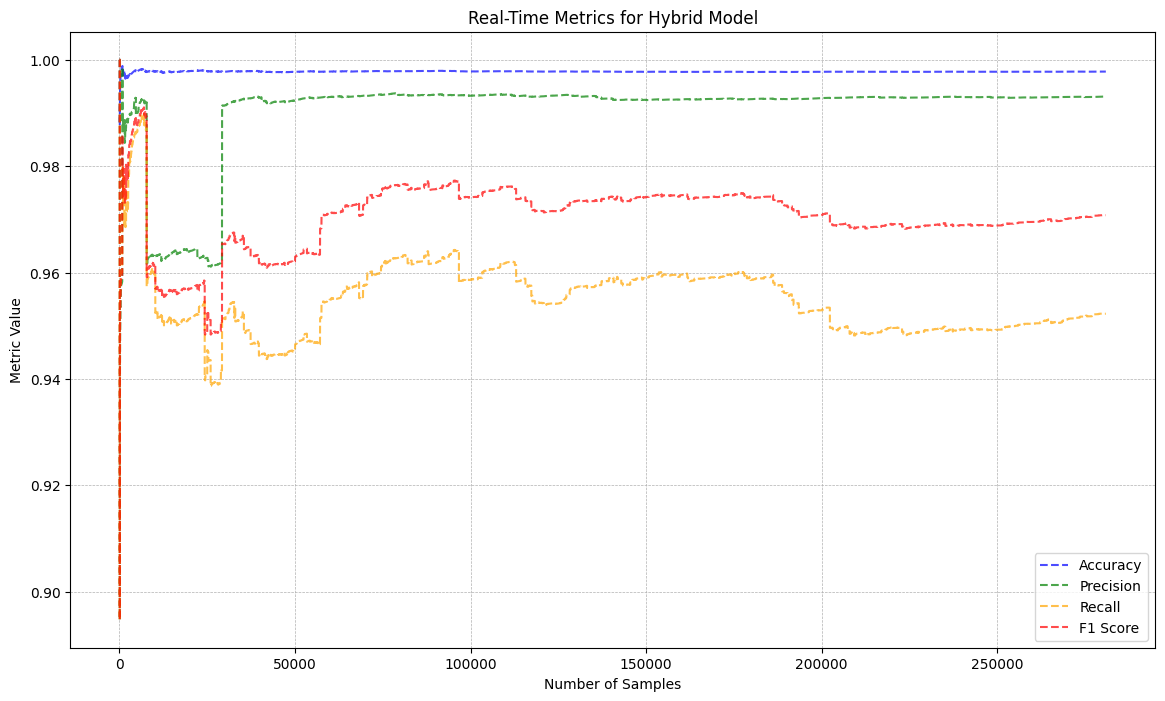

In [21]:
# Main loop for hybrid prediction
for x, y in dataset:
    start_time = time.time()  # Start time for runtime measurement
    
    num_samples += 1
    x_scaled = scaler.transform(pd.DataFrame([x]))  # Scale each streamed instance
    y_pred_offline = offline_model.predict(x_scaled)[0]
    y_pred_online = model_pipeline.predict_one(x)

    # Update accuracy buffers
    offline_accuracy = update_accuracy_buffer(accuracy_buffer_offline, y, y_pred_offline)
    online_accuracy = update_accuracy_buffer(accuracy_buffer_online, y, y_pred_online)

    # Decision logic: Select prediction from model with higher recent accuracy
    y_pred = y_pred_online if online_accuracy >= offline_accuracy else y_pred_offline

    # Check agreement between offline and online models
    if y_pred_offline == y_pred_online:
        agreement_count += 1

    # Append prediction to hybrid_predictions list
    hybrid_predictions.append(y_pred)

     # Calculate confidence score for online prediction, if available
    y_pred_online_prob = model_pipeline.predict_proba_one(x)
    confidence_score = max(y_pred_online_prob.values()) if y_pred_online_prob else None
    if confidence_score is not None:
        confidence_scores.append(confidence_score)

    # Update real-time metrics
    for name, metric in metrics_dict.items():
        metric.update(y, y_pred)
    
    # Append latest metrics for visualization
    accuracy_values.append(metrics_dict['Accuracy'].get())
    precision_values.append(metrics_dict['Precision'].get())
    recall_values.append(metrics_dict['Recall'].get())
    f1_values.append(metrics_dict['F1-score'].get())
   
    # Online model learning triggered by accuracy threshold
    if online_accuracy < accuracy_threshold:
        model_pipeline.learn_one(x, y)
        num_updates += 1
        degradation_instances += 1
           
    # Plot metrics every 50 samples
    if num_samples % 50 == 0:
        plot_metrics()

    # Runtime calculation
    end_time = time.time()
    total_time += (end_time - start_time)

In [22]:
# Final results after streaming
print("Final Performance Metrics of Hybrid Model:")
for name, metric in metrics_dict.items():
    print(f"{name}: {metric.get():.4f}")

Final Performance Metrics of Hybrid Model:
Accuracy: 0.9978
Precision: 0.9931
Recall: 0.9523
F1-score: 0.9708


In [23]:
# Print results
print(f"Processed samples: {num_samples}")
print(f"Sample {num_samples}: Prediction from {'Online' if y_pred == y_pred_online else 'Offline'} Model")
hybrid_pred_distribution = Counter(hybrid_predictions)
print(f"Hybrid Model Prediction Distribution: {dict(hybrid_pred_distribution)}")

Processed samples: 280985
Sample 280985: Prediction from Online Model
Hybrid Model Prediction Distribution: {8: 29610, 7: 19347, 3: 3051, 6: 17760, 19: 1387, 0: 54209, 1: 30541, 11: 6595, 10: 16419, 9: 18098, 14: 10786, 17: 4357, 5: 5410, 18: 8824, 15: 1787, 4: 15759, 13: 16494, 16: 11295, 24: 367, 2: 2873, 22: 2729, 21: 922, 20: 254, 12: 738, 25: 783, 31: 18, 32: 55, 26: 264, 28: 13, 27: 99, 30: 29, 29: 43, 23: 40, 33: 29}


In [24]:
print(f"Average Offline Model Accuracy: {offline_accuracy:.4f}")
print(f"Average Online Model Accuracy: {online_accuracy:.4f}")
print(f"Prediction Agreement Rate: {agreement_count / num_samples:.4f}")
if confidence_scores:
    avg_confidence = sum(confidence_scores) / len(confidence_scores)
    print(f"Average Online Model Confidence Score: {avg_confidence:.4f}")
recent_accuracy = sum(accuracy_buffer_online) / len(accuracy_buffer_online)
print(f"Recent Accuracy (last 100 samples): {recent_accuracy:.4f}")

Average Offline Model Accuracy: 1.0000
Average Online Model Accuracy: 0.7900
Prediction Agreement Rate: 0.7669
Average Online Model Confidence Score: 0.0745
Recent Accuracy (last 100 samples): 0.7900


In [25]:
print(f"Total Online Model Updates: {num_updates}")
print(f"Performance Degradation Instances: {degradation_instances}")

Total Online Model Updates: 280246
Performance Degradation Instances: 280246


In [26]:
print(f"Average Runtime per Sample: {total_time / num_samples:.4f} seconds")
throughput = num_samples / total_time
print(f"Throughput (samples per second): {throughput:.2f}")

Average Runtime per Sample: 0.0156 seconds
Throughput (samples per second): 64.04


In [27]:
print(f"Accuracy Threshold for Online Model Updates: {accuracy_threshold}")

Accuracy Threshold for Online Model Updates: 0.9


In [28]:
print("Decision Logic: Hybrid Prediction")
print(" - Prediction selected from the model with higher recent accuracy (last 100 samples).")
print(" - If offline and online predictions are equal, preference is given to the online model.")

Decision Logic: Hybrid Prediction
 - Prediction selected from the model with higher recent accuracy (last 100 samples).
 - If offline and online predictions are equal, preference is given to the online model.
